In [1]:
import pandas as pd  # pandas library for dataframe
import numpy as np   # numpy library for number
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from datetime import date

from sklearn.model_selection import train_test_split, GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
original_df = pd.read_csv("UK_SALES_DATA_FOR_ML.csv",encoding="latin1")

In [3]:
raw_df = original_df.copy()

In [4]:
raw_df['InvoiceDate'] = pd.to_datetime(raw_df['InvoiceDate'])
raw_df['Day_of_Week_Num'] = raw_df['InvoiceDate'].dt.weekday

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471669 entries, 0 to 471668
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   InvoiceNo        471669 non-null  int64         
 1   StockCode        471669 non-null  object        
 2   Description      471669 non-null  object        
 3   Quantity         471669 non-null  int64         
 4   InvoiceDate      471669 non-null  datetime64[ns]
 5   UnitPrice        471669 non-null  float64       
 6   CustomerID       471669 non-null  int64         
 7   Country          471669 non-null  object        
 8   Quantity_log     471669 non-null  float64       
 9   UnitPrice_log    471669 non-null  float64       
 10  Revenue          471669 non-null  int64         
 11  Revenue_log      471669 non-null  float64       
 12  Year             471669 non-null  int64         
 13  Month            471669 non-null  int64         
 14  Day              471

In [6]:
raw_df['Day_of_Week_Num']

0         2
1         2
2         2
3         2
4         2
         ..
471664    4
471665    4
471666    4
471667    4
471668    4
Name: Day_of_Week_Num, Length: 471669, dtype: int32

In [7]:
def calculate_iqr(series):
    # Calculate Q1 and Q3
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Calculate upper and lower fences
    upper_fence = Q3 + 1.5 * IQR
    lower_fence = Q1 - 1.5 * IQR
    
    # Print the fences
    print("Upper Fence =", upper_fence)
    print("Lower Fence =", lower_fence)
    
    # Return the fences for further use
    return lower_fence, upper_fence


In [8]:
raw_df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Quantity_log,UnitPrice_log,Revenue,Revenue_log,Year,Month,Day,Day_of_Week_Num
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,1.94591,1.266948,15,2.791165,2010,12,1,2


In [9]:
calculate_iqr(raw_df["Quantity_log"])

Upper Fence = 4.955017411
Lower Fence = -1.863974957


(-1.863974957, 4.955017411)

In [10]:
raw_df = raw_df[raw_df["Quantity_log"]<4.95]

In [11]:
calculate_iqr(raw_df["UnitPrice_log"])

Upper Fence = 2.87136895
Lower Fence = -0.4253330499999999


(-0.4253330499999999, 2.87136895)

In [12]:
raw_df = raw_df[raw_df["UnitPrice_log"]<2.87]

In [13]:
calculate_iqr(raw_df["Revenue_log"])

Upper Fence = 4.958196644601163
Lower Fence = -0.618962694983189


(-0.618962694983189, 4.958196644601163)

In [14]:
raw_df = raw_df[raw_df["Revenue_log"]<4.958]

In [15]:
raw_df.describe()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Quantity_log,UnitPrice_log,Revenue,Revenue_log,Year,Month,Day,Day_of_Week_Num
count,467470.000000,467470.000000,467470,467470.000000,467470.000000,467470.000000,467470.000000,467470.000000,467470.000000,467470.000000,467470.000000,467470.000000,467470.000000
mean,559966.425781,7.077817,2011-07-03 23:59:48.356044032,3.078431,15558.299457,1.615243,1.218116,12.487939,2.209310,2010.920053,7.571915,15.015466,2.439406
min,536365.000000,1.000000,2010-12-01 00:00:00,0.001000,12747.000000,0.693147,0.000999,0.000000,0.001000,2010.000000,1.000000,1.000000,0.000000
25%,547871.000000,1.000000,2011-03-27 00:00:00,1.250000,14159.000000,0.693147,0.810930,3.000000,1.472472,2011.000000,5.000000,7.000000,1.000000
50%,560580.000000,3.000000,2011-07-19 00:00:00,2.080000,15532.000000,1.386294,1.124929,8.000000,2.228939,2011.000000,8.000000,15.000000,2.000000
75%,572047.000000,10.000000,2011-10-20 00:00:00,4.130000,16950.000000,2.397895,1.635106,16.000000,2.862201,2011.000000,11.000000,22.000000,4.000000
max,581586.000000,140.000000,2011-12-09 00:00:00,16.630000,18287.000000,4.948760,2.869602,140.000000,4.955334,2011.000000,12.000000,31.000000,6.000000
std,13498.528795,10.887006,NaN,2.852475,1612.305075,0.890347,0.588372,15.990014,0.913860,0.271212,3.519931,8.686296,1.866160


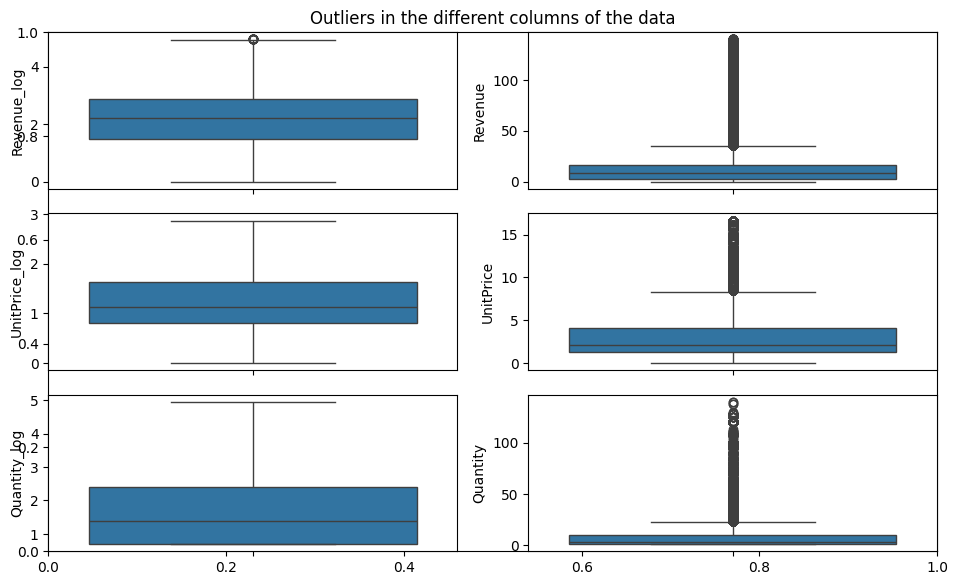

In [16]:
plt.figure(figsize=(10,6))
plt.title("Outliers in the different columns of the data")
plt.subplot(3,2,1)
sns.boxplot(raw_df["Revenue_log"])
plt.subplot(3,2,2)
sns.boxplot(raw_df["Revenue"])
plt.subplot(3,2,3)
sns.boxplot(raw_df["UnitPrice_log"])
plt.subplot(3,2,4)
sns.boxplot(raw_df["UnitPrice"])
plt.subplot(3,2,5)
sns.boxplot(raw_df["Quantity_log"])
plt.subplot(3,2,6)
sns.boxplot(raw_df["Quantity"])
plt.tight_layout()


In [17]:
raw_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Quantity_log', 'UnitPrice_log',
       'Revenue', 'Revenue_log', 'Year', 'Month', 'Day', 'Day_of_Week_Num'],
      dtype='object')

Mean Squared Error: 0.03
R-squared: 0.96


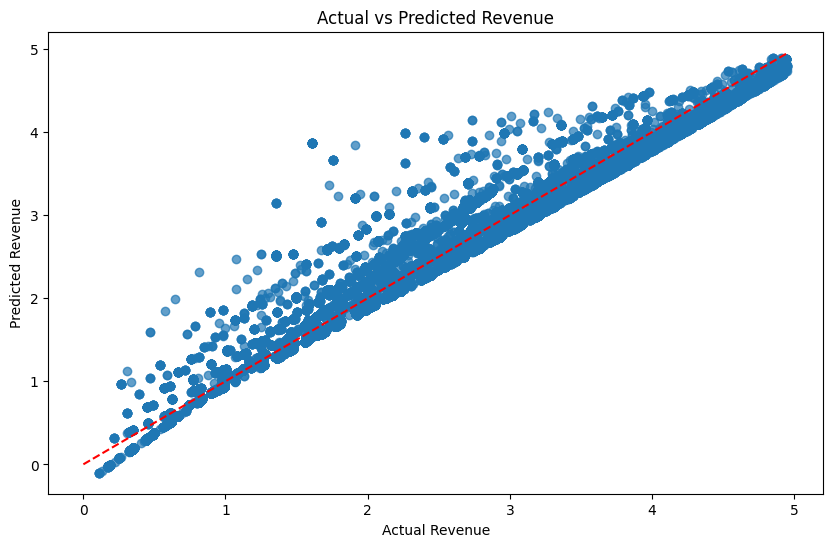

In [18]:
# Select features and target
X = raw_df[['Quantity_log', 'UnitPrice_log', 'Month', 'Day']]
y = raw_df['Revenue_log']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

# Plotting actual vs predicted revenue
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line for reference
plt.show()


In [19]:
X.corr()

,Quantity_log,UnitPrice_log,Month,Day
Quantity_log,1.000000,-0.426340,-0.012486,0.002432
UnitPrice_log,-0.426340,1.000000,-0.014074,-0.000015
Month,-0.012486,-0.014074,1.000000,-0.118373
Day,0.002432,-0.000015,-0.118373,1.000000


In [20]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define the features and target variable
X = raw_df[['Quantity_log', 'UnitPrice_log', 'Month', 'Day']]
y = raw_df['Revenue']

# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=30, max_depth=7, max_features='sqrt', random_state=42)

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation (using MSE as the scoring metric)
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(mean_squared_error))

# Calculate the mean and standard deviation of the MSE across folds
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f'Mean MSE: {mean_mse:.2f}')
print(f'Standard Deviation of MSE: {std_mse:.2f}')

# You can also check the R-squared scores using a similar approach
r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f'Mean R-squared: {mean_r2:.2f}')
print(f'Standard Deviation of R-squared: {std_r2:.2f}')


Mean MSE: 9.79
Standard Deviation of MSE: 0.88
Mean R-squared: 0.96
Standard Deviation of R-squared: 0.00


# Customer Purchase Prediction

In [21]:
customer_data = raw_df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',     # Number of purchases
    'Quantity': 'sum',          # Total quantity purchased
    'Revenue': 'sum',           # Total revenue generated
    'InvoiceDate': ['min', 'max'],  # First and last purchase dates
}).reset_index()

# Rename columns for clarity
customer_data.columns = ['CustomerID', 'Unique_Invoice', 'Total_Quantity', 'Total_Revenue', 'First_Purchase', 'Last_Purchase']


In [22]:
customer_data

,CustomerID,Unique_Invoice,Total_Quantity,Total_Revenue,First_Purchase,Last_Purchase
0,12747,11,1059,2773,2010-12-05,2011-12-07
1,12748,218,23636,34134,2010-12-01,2011-12-09
2,12749,6,1800,5315,2011-05-10,2011-12-06
3,12820,4,722,916,2011-01-17,2011-12-06
4,12821,1,70,90,2011-05-09,2011-05-09
...,...,...,...,...,...,...
3842,18280,6,1264,5257,2011-03-07,2011-03-07
3843,18281,1,52,46,2011-06-12,2011-06-12
3844,18282,2,103,171,2011-08-05,2011-12-02
3845,18283,17,2132,3172,2011-01-06,2011-12-06


Recency, Frequency, Monetary (RFM) Features: Create additional features that capture key aspects of customer behavior: <br>
Recency: Days since the last purchase.<br>
Frequency: Number of purchases made.<br>
Monetary: Total amount spent.<br>

In [23]:
# Calculate Recency
customer_data['Recency'] = (pd.to_datetime(date.today()) - customer_data['Last_Purchase']).dt.days
customer_data['Avg_Order_Value'] = customer_data['Total_Revenue'] / customer_data['Unique_Invoice']

# Frequency and Monetary are already included in the aggregated data (Num_Purchases and Total_Revenue)


In [24]:
customer_data['Recency'].median()

4700.0

In [25]:
# Example: Target is 1 if the customer made a purchase within the last 30 days, otherwise 0
customer_data['Target'] = customer_data['Recency'].apply(lambda x: 1 if x <= customer_data['Recency'].median() else 0)
customer_data['Target'].value_counts()

Target
1    1939
0    1908
Name: count, dtype: int64

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split data into features (X) and target (y)
X = customer_data[['Unique_Invoice', 'Total_Quantity', 'Total_Revenue', 'Recency', 'Avg_Order_Value']]
y = customer_data['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)


In [27]:
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[341   0]
 [  0 429]]


In [28]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       341
           1       1.00      1.00      1.00       429

    accuracy                           1.00       770
   macro avg       1.00      1.00      1.00       770
weighted avg       1.00      1.00      1.00       770



In [29]:
feature_importances = model.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance}')
    

Unique_Invoice: 0.06009626687285456
Total_Quantity: 0.032475564543536985
Total_Revenue: 0.01950699240227351
Recency: 0.882190967454011
Avg_Order_Value: 0.005730208727323961


In [30]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 467470 entries, 0 to 471668
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   InvoiceNo        467470 non-null  int64         
 1   StockCode        467470 non-null  object        
 2   Description      467470 non-null  object        
 3   Quantity         467470 non-null  int64         
 4   InvoiceDate      467470 non-null  datetime64[ns]
 5   UnitPrice        467470 non-null  float64       
 6   CustomerID       467470 non-null  int64         
 7   Country          467470 non-null  object        
 8   Quantity_log     467470 non-null  float64       
 9   UnitPrice_log    467470 non-null  float64       
 10  Revenue          467470 non-null  int64         
 11  Revenue_log      467470 non-null  float64       
 12  Year             467470 non-null  int64         
 13  Month            467470 non-null  int64         
 14  Day              467470 n

In [31]:
customer_data

,CustomerID,Unique_Invoice,Total_Quantity,Total_Revenue,First_Purchase,Last_Purchase,Recency,Avg_Order_Value,Target
0,12747,11,1059,2773,2010-12-05,2011-12-07,4652,252.090909,1
1,12748,218,23636,34134,2010-12-01,2011-12-09,4650,156.577982,1
2,12749,6,1800,5315,2011-05-10,2011-12-06,4653,885.833333,1
3,12820,4,722,916,2011-01-17,2011-12-06,4653,229.000000,1
4,12821,1,70,90,2011-05-09,2011-05-09,4864,90.000000,0
...,...,...,...,...,...,...,...,...,...
3842,18280,6,1264,5257,2011-03-07,2011-03-07,4927,876.166667,0
3843,18281,1,52,46,2011-06-12,2011-06-12,4830,46.000000,0
3844,18282,2,103,171,2011-08-05,2011-12-02,4657,85.500000,1
3845,18283,17,2132,3172,2011-01-06,2011-12-06,4653,186.588235,1


In [32]:
raw_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Quantity_log', 'UnitPrice_log',
       'Revenue', 'Revenue_log', 'Year', 'Month', 'Day', 'Day_of_Week_Num'],
      dtype='object')

In [33]:
raw_df["StockCode"].value_counts().sort_index

<bound method Series.sort_index of StockCode
85123A    2063
85099B    1764
47566     1454
20725     1358
84879     1338
          ... 
21686        1
90021        1
84856S       1
37461        1
72783        1
Name: count, Length: 3862, dtype: int64>

In [34]:
raw_df[['UnitPrice_log', 'Year', 'Month', 'Day', 'Day_of_Week_Num']]

,UnitPrice_log,Year,Month,Day,Day_of_Week_Num
0,1.266948,2010,12,1,2
1,1.479329,2010,12,1,2
2,1.321756,2010,12,1,2
3,1.479329,2010,12,1,2
4,1.479329,2010,12,1,2
...,...,...,...,...,...
471663,0.667829,2011,12,9,4
471664,1.081805,2011,12,9,4
471665,1.373716,2011,12,9,4
471666,0.810930,2011,12,9,4


In [2]:
sales_forcasting = raw_df.groupby("InvoiceDate").agg({
    "Quantity_log": "sum",
    "UnitPrice_log": "sum",
    }).reset_index()

NameError: name 'raw_df' is not defined

In [3]:
sales_forcasting["Revenue_log"] = sales_forcasting["Quantity_log"] * sales_forcasting["UnitPrice_log"]
sales_forcasting["date"] = sales_forcasting["InvoiceDate"].dt.day
sales_forcasting["month"] = sales_forcasting["InvoiceDate"].dt.month
sales_forcasting["year"] = sales_forcasting["InvoiceDate"].dt.year
sales_forcasting["day_of_week"] = sales_forcasting["InvoiceDate"].dt.dayofweek
sales_forcasting['Revenue_lag1'] = sales_forcasting['Revenue_log'].shift(1)
sales_forcasting['Revenue_rolling_mean_7'] = sales_forcasting['Revenue_log'].rolling(window=7).mean()
sales_forcasting['Revenue_log'] = sales_forcasting['Revenue_log'].shift(-1)

NameError: name 'sales_forcasting' is not defined

In [4]:
sales_forcasting.head()

NameError: name 'sales_forcasting' is not defined

In [38]:
sales_forcasting.dropna(inplace=True)

In [1]:
sales_forcasting.tail()

NameError: name 'sales_forcasting' is not defined

NameError: name 'sns' is not defined

In [41]:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler
    
    # Features and target variable
    X = sales_forcasting[['day_of_week','year','Revenue_rolling_mean_7']]
    y = sales_forcasting['Revenue_log']
    scaler = StandardScaler()
    
    # Fit the scaler on the training data and transform the features
    X_scaled = scaler.fit_transform(X)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"RMSE: {rmse}")

RMSE: 9771585.648921695


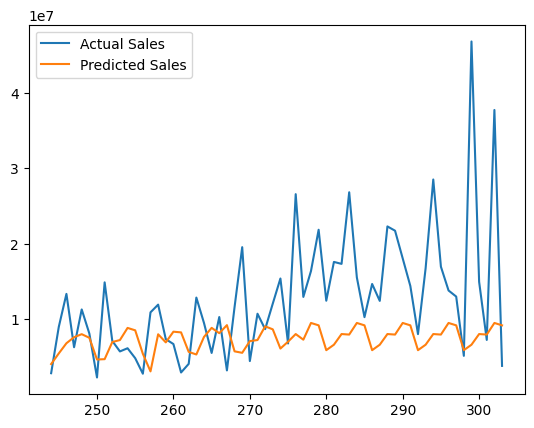

In [42]:
plt.plot(y_test.index, y_test, label='Actual Sales')
plt.plot(y_test.index, predictions, label='Predicted Sales')
plt.legend()
plt.show()


In [43]:
feature_importances = model.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance}')
    

day_of_week: 0.19493808121335685
year: 0.0221446250776826
Revenue_rolling_mean_7: 0.7829172937089605


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler

# Features and target variable
X = sales_forcasting[['day_of_week','year','Revenue_rolling_mean_7']]
y = sales_forcasting['Revenue_log']
scaler = StandardScaler()

# Fit the scaler on the training data and transform the features
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_predictions = gb_model.predict(X_test)

# Calculate RMSE
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))
print(f"Gradient Boosting RMSE: {gb_rmse}")


NameError: name 'sales_forcasting' is not defined

ModuleNotFoundError: No module named 'xgboost'